Authors: Alvin Vinod Chandran

### This Jupyter Notebook file runs a decision tree algorithm for regression calculation of real estate data.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
df=pd.read_csv('/content/real_estate_dataset/realest_data.csv', index_col=False)
df.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [3]:
X = df.drop(['Y house price of unit area'], axis=1)
y = df['Y house price of unit area']

In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
model = DecisionTreeRegressor(random_state=42)

model.fit(X_train, y_train)

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

print(f"Cross-validation R² scores: {cv_scores}")
print(f"Average CV R² score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Cross-validation R² scores: [ 0.53104457 -0.55843726  0.32873738  0.73746465  0.51019141]
Average CV R² score: 0.3098 (+/- 0.9061)


In [6]:
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

results = {
    'MSE': mse,
    'RMSE': np.sqrt(mse),
    'R2': r2
}

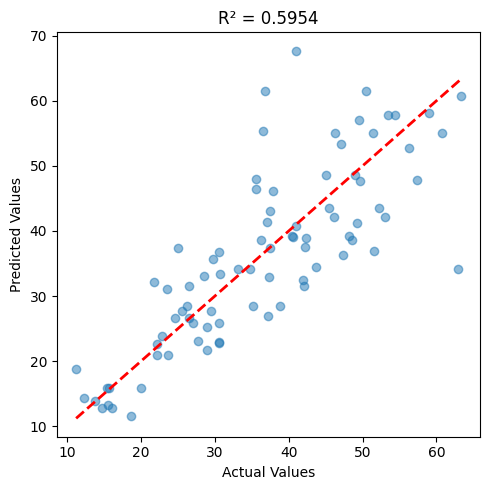

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

y_pred = model.predict(X_test)

axes.scatter(y_test, y_pred, alpha=0.5)
axes.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes.set_xlabel('Actual Values')
axes.set_ylabel('Predicted Values')
axes.set_title(f'R² = {r2_score(y_test, y_pred):.4f}')

plt.tight_layout()
plt.show()

In [13]:
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12],
    'max_features': [0.5, 0.7, 0.9, 'sqrt', 'log2', None],
}


dt_model = DecisionTreeRegressor(random_state=42)


grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best cross-validation score:", best_score)

# Train the model with best parameters
best_model = DecisionTreeRegressor(**best_params, random_state=42)
best_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_best = best_model.predict(X_test_scaled)

# Calculate metrics for the best model
best_mse = mean_squared_error(y_test, y_pred_best)
best_r2 = r2_score(y_test, y_pred_best)

# Print improvement
print("\nModel Performance Comparison:")
print(f"Original R² score: {r2:.4f}")
print(f"Tuned R² score: {best_r2:.4f}")
print(f"Improvement: {(best_r2 - r2) * 100:.2f}%")

Fitting 5 folds for each of 1470 candidates, totalling 7350 fits
Best parameters: {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 8, 'min_samples_split': 2}
Best cross-validation score: 0.6270668668115645

Model Performance Comparison:
Original R² score: 0.5954
Tuned R² score: 0.7441
Improvement: 14.87%


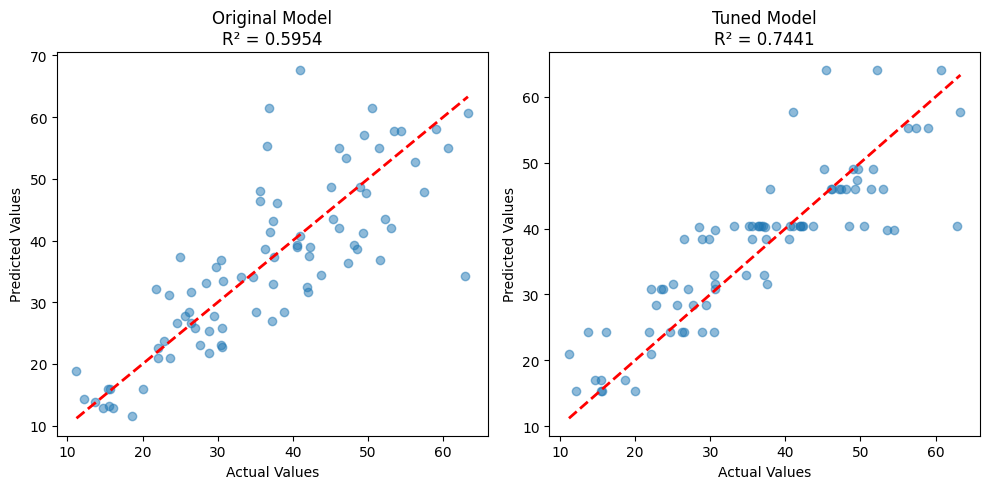

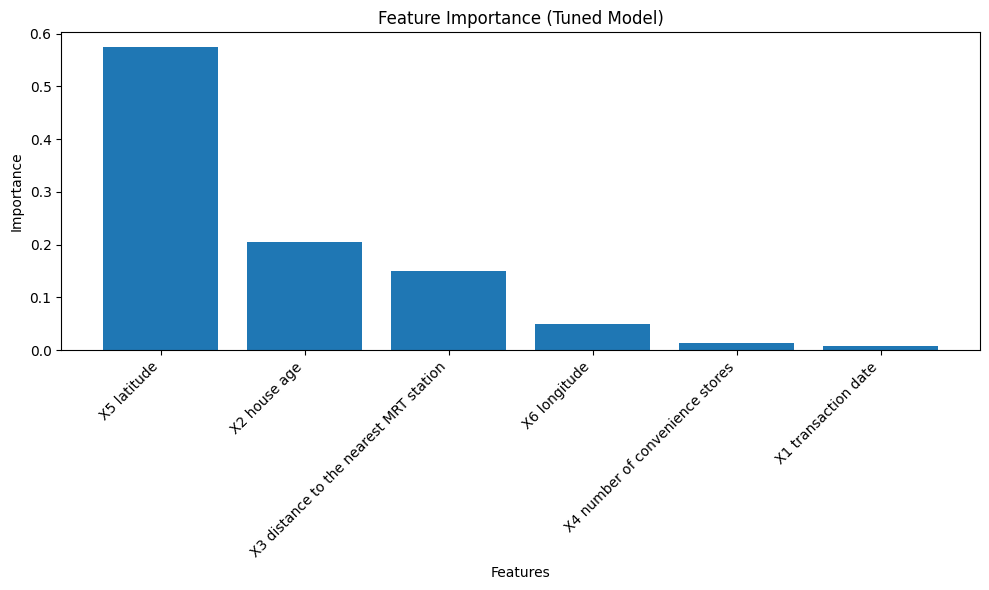

In [14]:
plt.figure(figsize=(10, 5))

# Original model predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Original Model\nR² = {r2:.4f}')

# Tuned model predictions
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Tuned Model\nR² = {best_r2:.4f}')

plt.tight_layout()
plt.show()

# Feature importance for the tuned model
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
})

# Sort the features by importance
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (Tuned Model)')
plt.tight_layout()
plt.show()

# REPORT
------


1.